In [1]:
# Load base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

# load stats tools
from scipy import stats

# load dataset tools
import datasets

# preprocessing tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# load models
from sklearn.linear_model import LogisticRegression
import torch
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from transformers import EvalPrediction

# load eval tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

# Load Data

In [2]:
anno_df = pd.read_csv("data/AnnotatedData/AnnotatedDUGData.tsv", sep="\t")
load_shape = anno_df.shape

# Prepare data

In [3]:
# we will drop the columns which we are not interested in
anno_df = anno_df[
    [
        "Drug number",
        "Line number",
        "Advice Text",
        "AdviceTag1",
        "AdviceTag2",
        "AdviceTag3",
        "AdviceTag4",
    ]
]

## Extract label_ids

In [4]:
labels = (
    anno_df[["AdviceTag1", "AdviceTag2", "AdviceTag3", "AdviceTag4"]]
    .fillna("")
    .astype(str)
)

label_ids = list(set(labels.values.flatten()))

# remove the empty string
label_ids.remove("")


n_label_ids = len(label_ids)
n_label_ids

8

## Encode advice labels

In [5]:
# Create new columns for each unique tag and initialize them with 0
for lab in label_ids:
    anno_df[lab] = 0

# Update the values to 1 where the tag is present
for lab in label_ids:
    mask = labels.apply(lambda row: lab in row.values, axis=1)
    anno_df.loc[mask, lab] = 1

# Drop the original AdviceTag columns
anno_df.drop(
    columns=["AdviceTag1", "AdviceTag2", "AdviceTag3", "AdviceTag4"],
    inplace=True,
)

# Save the transformed data to a new file
anno_df.head()

,Drug number,Line number,Advice Text,Drug administration related,Temporal,Disease or symptom related,Other drugs related,Pregnancy related,Activity or lifestyle related,Food or beverage related,Exercise related
0,0,34,To reduce the risk of dizziness and lightheade...,0,0,0,0,0,1,0,0
1,0,38,This medication may rarely make your blood sug...,0,0,1,0,0,0,0,0
2,0,43,This medication may rarely cause a condition k...,0,0,1,0,0,0,0,0
3,0,64,This drug may make you dizzy or drowsy or caus...,0,0,1,0,0,1,0,0
4,0,66,Avoid alcoholic beverages.,0,0,0,0,0,0,1,0


### Ensure the encoding was correct

In [6]:
assert anno_df.shape[0] == load_shape[0], "Mismatch in number of rows"

# Baseline Predictions


Two baselines will be tested with for the multilabel classification task.

The  baseline will be a random baseline, where the labels are randomly assigned to the advice text.

The baseline will be evaluated using the F1 score, Precision, and Recall.

In [7]:
def rand_baseline_pred(dataset, n_labels=8):
    """
    Randomly predicts a label for each example in the dataset.

    Args:
        dataset (datasets.Dataset): The dataset to predict labels for.

    Returns:
        np.ndarray: The predicted labels.
    """

    return np.random.randint(0, 2, size=(len(dataset), n_labels))

## Load data into dataset

In [8]:
multi_label = datasets.Dataset.from_pandas(anno_df)

## Evaluate the baseline

### Identify ground truth labels

In [9]:
ground_truth = anno_df[label_ids].values

In [10]:
assert ground_truth.shape[0] == load_shape[0], "Mismatch in number of rows"
assert ground_truth.shape[1] == n_label_ids, "Mismatch in number of columns"

### Make predictions and evaluate

#### Random Baseline

In [11]:
# make predictions
rand_preds = rand_baseline_pred(multi_label)
# print(rand_preds.shape)
precision, recall, f1, _ = precision_recall_fscore_support(
    ground_truth, rand_preds, average="micro"
)
print(f"Random Precision: {precision}, Recall: {recall}, F1: {f1}")

Random Precision: 0.19147325933400605, Recall: 0.47113594040968343, F1: 0.2722869955156951


# Train, Test Split

In [12]:
anno_df.columns

Index(['Drug number', 'Line number', 'Advice Text',
       'Drug administration related', 'Temporal', 'Disease or symptom related',
       'Other drugs related', 'Pregnancy related',
       'Activity or lifestyle related', 'Food or beverage related',
       'Exercise related'],
      dtype='object')

In [13]:
# Drop the unneeded columns
anno_df.drop(["Drug number", "Line number"], axis=1, inplace=True)

# Create train test split
train, test = train_test_split(anno_df, test_size=0.2, random_state=42)

# Binary Relevance

For binary relevance we will encode the text using a TF-IDF vectorizer and then train a logistic regression model for each label.

In [14]:
# look at our data
train.head()

,Advice Text,Drug administration related,Temporal,Disease or symptom related,Other drugs related,Pregnancy related,Activity or lifestyle related,Food or beverage related,Exercise related
78,Some products that may interact with this drug...,0,0,0,1,0,0,0,0
29,"Beta-blocker medications (such as metoprolol, ...",0,0,1,1,0,0,0,0
280,Wash your hands after applying the patch.,1,0,0,0,0,1,0,0
507,Lithium passes into breast milk and may have u...,0,0,0,0,1,0,0,0
652,Limit alcoholic beverages.,0,0,0,0,0,0,1,0


## Data encoding with TF-IDF

In [15]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the train data
X_train = vectorizer.fit_transform(train["Advice Text"])

# Transform the test data
X_test = vectorizer.transform(test["Advice Text"])

label_ids = train.columns[1:]
label_ids

Index(['Drug administration related', 'Temporal', 'Disease or symptom related',
       'Other drugs related', 'Pregnancy related',
       'Activity or lifestyle related', 'Food or beverage related',
       'Exercise related'],
      dtype='object')

### Training

In [16]:
# Initialize the model
model = LogisticRegression(max_iter=1000)

In [17]:
results = pd.DataFrame()
for label in label_ids:
    print(f"Training model for {label}")
    y_train = train[label]
    y_test = test[label]

    # Train the model
    model.fit(X_train, y_train)

    # Predict the test data
    preds = model.predict(X_test)

    # Evaluate the model
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, preds, average="binary"
    )
    print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")

    results[label] = preds

# Evaluate the model
precision, recall, f1, _ = precision_recall_fscore_support(
    test[label_ids], results, average="micro"
)
print(f"\nPrecision: {precision}, Recall: {recall}, F1: {f1}")

Training model for Drug administration related
Precision: 1.0, Recall: 0.5333333333333333, F1: 0.6956521739130436
Training model for Temporal
Precision: 0.8571428571428571, Recall: 0.5142857142857142, F1: 0.6428571428571428
Training model for Disease or symptom related
Precision: 0.6578947368421053, Recall: 0.5208333333333334, F1: 0.5813953488372092
Training model for Other drugs related
Precision: 0.9310344827586207, Recall: 0.8307692307692308, F1: 0.8780487804878049
Training model for Pregnancy related
Precision: 1.0, Recall: 0.8636363636363636, F1: 0.9268292682926829
Training model for Activity or lifestyle related
Precision: 1.0, Recall: 0.38461538461538464, F1: 0.5555555555555556
Training model for Food or beverage related
Precision: 0.8787878787878788, Recall: 0.6904761904761905, F1: 0.7733333333333333
Training model for Exercise related
Precision: 0.0, Recall: 0.0, F1: 0.0

Precision: 0.8918918918918919, Recall: 0.6346153846153846, F1: 0.7415730337078652


c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# store results for later
model_results = []
model_results.append(
    {
        "model": "Binary Relevance LR",
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
)

# Transformer Based Model

In [19]:
train, val = train_test_split(train, test_size=0.3, random_state=42)

In [20]:
model_id = "roberta-base"

### Load data into dataset

In [21]:
# Load into datasets
train_dataset = datasets.Dataset.from_pandas(train, preserve_index=False)
val_dataset = datasets.Dataset.from_pandas(val, preserve_index=False)
test_dataset = datasets.Dataset.from_pandas(test, preserve_index=False)

In [22]:
# rename Advice Text to text
train_dataset = train_dataset.rename_column("Advice Text", "text")
val_dataset = val_dataset.rename_column("Advice Text", "text")
test_dataset = test_dataset.rename_column("Advice Text", "text")

### Tokenize and split text

In [23]:
tokenizer = RobertaTokenizer.from_pretrained(model_id)

In [24]:
def preprocess_text(batch):

    text = batch["text"]
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )

    labels = list(batch.keys())[1:]

    label_array = np.zeros((len(text), len(labels)))

    for i, label in enumerate(labels):
        label_array[:, i] = batch[label]

    inputs["labels"] = label_array

    return inputs

In [25]:
train_encodings = train_dataset.map(preprocess_text, batched=True)
eval_encodings = val_dataset.map(preprocess_text, batched=True)
test_encodings = test_dataset.map(preprocess_text, batched=True)

Map:   0%|          | 0/562 [00:00<?, ? examples/s]

Map:   0%|          | 0/242 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

In [26]:
# format datasets
train_encodings.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)
eval_encodings.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)
test_encodings.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)

In [27]:
# example
example = train_encodings[0]
print(example["input_ids"].shape)
print(example["attention_mask"].shape)
print(example["labels"].shape)

print(tokenizer.decode(example["input_ids"]))

torch.Size([512])
torch.Size([512])
torch.Size([8])
<s>If you are planning pregnancy, become pregnant, or think you may be pregnant, immediately discuss the benefits and risks of using this medication during pregnancy with your doctor.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

#### Label Information

In [28]:
class_names = anno_df.columns[1:].tolist()
n_labels = len(class_names)

id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}

In [29]:
# metrics function
def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids

    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    preds = (probs > 0.5).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="micro"
    )

    return {"precision": precision, "recall": recall, "f1": f1}

### Train

In [30]:
training_args = TrainingArguments(
    output_dir="./models/roberta-base",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    eval_steps=25,
    logging_dir=f"./logs",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    save_strategy="steps",
    save_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    report_to="wandb",
)

In [31]:
model = RobertaForSequenceClassification.from_pretrained(
    model_id, num_labels=n_labels, id2label=id2label, label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encodings,
    eval_dataset=eval_encodings,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [33]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mattcalc. Use `wandb login --relogin` to force relogin


  0%|          | 0/213 [00:00<?, ?it/s]

{'loss': 0.6951, 'grad_norm': 1.4393723011016846, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.14}
{'loss': 0.6903, 'grad_norm': 0.8597822189331055, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.28}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.6801167726516724, 'eval_precision': 0.197098976109215, 'eval_recall': 0.6111111111111112, 'eval_f1': 0.2980645161290323, 'eval_runtime': 4.9229, 'eval_samples_per_second': 49.158, 'eval_steps_per_second': 6.297, 'epoch': 0.35}
{'loss': 0.6812, 'grad_norm': 1.2141214609146118, 'learning_rate': 3e-06, 'epoch': 0.42}
{'loss': 0.6718, 'grad_norm': 1.1345133781433105, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.56}
{'loss': 0.6464, 'grad_norm': 3.1499133110046387, 'learning_rate': 5e-06, 'epoch': 0.7}


  0%|          | 0/31 [00:00<?, ?it/s]

c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.6378305554389954, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 4.4975, 'eval_samples_per_second': 53.808, 'eval_steps_per_second': 6.893, 'epoch': 0.7}
{'loss': 0.6129, 'grad_norm': 2.075239419937134, 'learning_rate': 6e-06, 'epoch': 0.85}
{'loss': 0.5472, 'grad_norm': 1.5237269401550293, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.99}


  0%|          | 0/31 [00:00<?, ?it/s]

c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.480112761259079, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 4.5, 'eval_samples_per_second': 53.778, 'eval_steps_per_second': 6.889, 'epoch': 1.06}
{'loss': 0.5074, 'grad_norm': 1.7716951370239258, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.13}
{'loss': 0.4726, 'grad_norm': 1.439871907234192, 'learning_rate': 9e-06, 'epoch': 1.27}
{'loss': 0.4345, 'grad_norm': 1.7503074407577515, 'learning_rate': 1e-05, 'epoch': 1.41}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.3946533799171448, 'eval_precision': 0.9764705882352941, 'eval_recall': 0.21957671957671956, 'eval_f1': 0.3585313174946004, 'eval_runtime': 4.499, 'eval_samples_per_second': 53.789, 'eval_steps_per_second': 6.89, 'epoch': 1.41}
{'loss': 0.4081, 'grad_norm': 1.4410768747329712, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.55}
{'loss': 0.3604, 'grad_norm': 1.7180413007736206, 'learning_rate': 1.2e-05, 'epoch': 1.69}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.3142295479774475, 'eval_precision': 0.9008264462809917, 'eval_recall': 0.5767195767195767, 'eval_f1': 0.7032258064516129, 'eval_runtime': 4.9997, 'eval_samples_per_second': 48.403, 'eval_steps_per_second': 6.2, 'epoch': 1.76}
{'loss': 0.3483, 'grad_norm': 2.2748496532440186, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.83}
{'loss': 0.333, 'grad_norm': 1.8120030164718628, 'learning_rate': 1.4000000000000001e-05, 'epoch': 1.97}
{'loss': 0.284, 'grad_norm': 2.705533027648926, 'learning_rate': 1.5e-05, 'epoch': 2.11}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.2656218707561493, 'eval_precision': 0.888135593220339, 'eval_recall': 0.6931216931216931, 'eval_f1': 0.7786032689450223, 'eval_runtime': 4.4981, 'eval_samples_per_second': 53.801, 'eval_steps_per_second': 6.892, 'epoch': 2.11}
{'loss': 0.2619, 'grad_norm': 1.4024584293365479, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.25}
{'loss': 0.2478, 'grad_norm': 1.6559019088745117, 'learning_rate': 1.7000000000000003e-05, 'epoch': 2.39}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.2202891856431961, 'eval_precision': 0.9255663430420712, 'eval_recall': 0.7566137566137566, 'eval_f1': 0.8326055312954876, 'eval_runtime': 4.5038, 'eval_samples_per_second': 53.732, 'eval_steps_per_second': 6.883, 'epoch': 2.46}
{'loss': 0.2384, 'grad_norm': 2.2262051105499268, 'learning_rate': 1.8e-05, 'epoch': 2.54}
{'loss': 0.2226, 'grad_norm': 2.2971575260162354, 'learning_rate': 1.9e-05, 'epoch': 2.68}
{'loss': 0.2156, 'grad_norm': 1.6027638912200928, 'learning_rate': 2e-05, 'epoch': 2.82}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.1976104974746704, 'eval_precision': 0.9039039039039038, 'eval_recall': 0.7962962962962963, 'eval_f1': 0.8466947960618847, 'eval_runtime': 4.495, 'eval_samples_per_second': 53.837, 'eval_steps_per_second': 6.897, 'epoch': 2.82}
{'loss': 0.2132, 'grad_norm': 1.6336114406585693, 'learning_rate': 2.1e-05, 'epoch': 2.96}
{'train_runtime': 153.522, 'train_samples_per_second': 10.982, 'train_steps_per_second': 1.387, 'train_loss': 0.4297500457002523, 'epoch': 3.0}


TrainOutput(global_step=213, training_loss=0.4297500457002523, metrics={'train_runtime': 153.522, 'train_samples_per_second': 10.982, 'train_steps_per_second': 1.387, 'train_loss': 0.4297500457002523, 'epoch': 3.0})

In [34]:
trainer.evaluate()

  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.1976104974746704,
 'eval_precision': 0.9039039039039038,
 'eval_recall': 0.7962962962962963,
 'eval_f1': 0.8466947960618847,
 'eval_runtime': 4.8825,
 'eval_samples_per_second': 49.565,
 'eval_steps_per_second': 6.349,
 'epoch': 3.0}

In [35]:
# evaluate on test set
test_results = trainer.predict(test_encodings)

test_metrics = compute_metrics(test_results)
print(test_metrics)

  0%|          | 0/26 [00:00<?, ?it/s]

{'precision': 0.9188191881918819, 'recall': 0.7980769230769231, 'f1': 0.8542024013722128}


In [36]:
model_results.append(
    {
        "model": "RoBERTa",
        "precision": test_metrics["precision"],
        "recall": test_metrics["recall"],
        "f1": test_metrics["f1"],
    }
)

# Model Results

In [37]:
# plot model results
model_results_df = pd.DataFrame(model_results)
model_results_df

,model,precision,recall,f1
0,Binary Relevance LR,0.891892,0.634615,0.741573
1,RoBERTa,0.918819,0.798077,0.854202


In [38]:
# stack precision, recall, f1
model_results_df = model_results_df.melt(id_vars="model", var_name="metric")
model_results_df

,model,metric,value
0,Binary Relevance LR,precision,0.891892
1,RoBERTa,precision,0.918819
2,Binary Relevance LR,recall,0.634615
3,RoBERTa,recall,0.798077
4,Binary Relevance LR,f1,0.741573
5,RoBERTa,f1,0.854202


c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

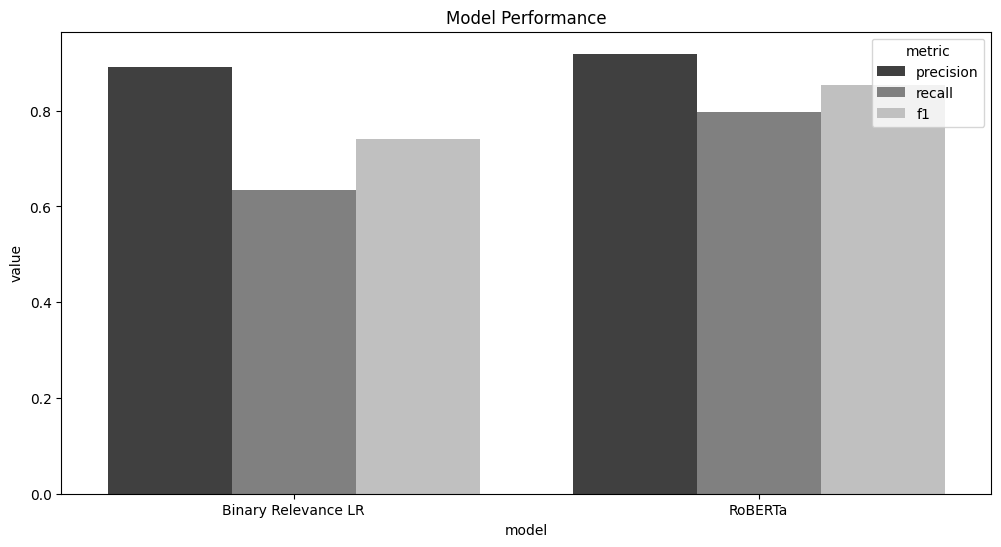

In [43]:
# plot results
plt.figure(figsize=(12, 6))
sns.barplot(
    x="model", y="value", hue="metric", data=model_results_df, palette="gray"
)
plt.title("Model Performance")
plt.show()